In [1]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget
import gc

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

In [2]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [3]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')



In [4]:
import load_data_utils as utils # ldu just seemed confusing!
print('My env_info: \n' + utils.get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: 


In [5]:
def get_dataset(dataset):
    if (dataset == 'MobiAct HAR'):
        if (os.path.exists('MobiAct_Dataset_v1.0.zip')):
            print ("Local MobiAct zip found, skipping download")
        else:
            !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
        # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
        # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
        get_py_file(fname = 'mobiact_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
        from mobiact_adl_load_dataset import mobiact_adl_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
        k_size = 50
        EPOCHS = 50
        t_names = ['JOG','JUM','STD','STN','STU','WAL']
    elif (dataset == 'UniMiB SHAR'):
        get_py_file(fname = 'unimib_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
        from unimib_adl_load_dataset import unimib_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
        t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
        k_size = 50
        EPOCHS = 60
    elif (dataset == 'UCI HAR'):
        get_py_file(fname = 'uci_har_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
        from uci_har_load_dataset import uci_har_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
        t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
        k_size = 50
        EPOCHS = 120
    elif (dataset == 'TWristAR'):
        # Note TWristAR is more updated than the previous datasets so the accesses
        # and defaults are a bit different, e.g. t_names is pulled from the .py
        get_py_file(fname = 'twristar_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar_load_dataset # diff to get label map
        x_train, y_train, x_valid, y_valid, x_test, y_test \
                                = twristar_load_dataset.twristar_load_dataset(
                                    incl_val_group = True,
                                    one_hot_encode = True)
        t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
        t_names.remove('Undefined')
        k_size = 16
        EPOCHS = 100
    elif (dataset == 'Leotta_2021'):
        get_py_file(fname = 'leotta_2021_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
        #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
        #shutil.copy(full_filename,'leotta_2021_load_dataset.py')

        import leotta_2021_load_dataset as leotta_2021_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True, one_hot_encode = True)
        t_names = list(leotta_2021_load_dataset.label_map_leotta.get('label').keys())
        k_size = 100
        EPOCHS = 50
    elif (dataset == 'SHL'):
        # SHL takes about 30 minutes to process due to size, using saved arrays for now
        !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
        utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
        input_dir = './SHL'
        x_train = np.load(input_dir + '/'+'x_train.npy')
        x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
        x_test = np.load(input_dir + '/'+'x_test.npy')
        x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
        y_train = np.load(input_dir + '/'+'y_train.npy')
        y_test = np.load(input_dir + '/'+'y_test.npy')
        # also don't have validate working in SHL so just using stratify
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

        t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
        k_size = 15
        EPOCHS = 100
    elif (dataset == 'Gesture Phase Segmentation'):
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                                = gesture_phase_segmentation_load_dataset(
                                    incl_val_group = True,
                                    return_info_dict = True)
        print("Note: Due to the size of the Gesture Phase Segmentation and for",
            "\ncompatibility, the test arrays are copies of the valid arrays")
        x_test = x_valid.copy()
        y_test = y_valid.copy()
        t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
        k_size = 9
        EPOCHS = 100
    else:
        print('ERROR: dataset unknown')
    print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                    'x_valid':x_valid,'y_valid':y_valid,
                                    'x_test':x_test,'y_test':y_test}))
    return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names


In [6]:
ds_list = ["UniMiB SHAR",
           "UCI HAR",
           "TWristAR",
           "Leotta_2021",
           "Gesture Phase Segmentation"
           ]


In [7]:
def learn_cpts(y, k):
    """
    Learn and return the Conditional Probability Tables (CPTs) for a given sequence of class labels.

    Args:
    y (list): An array of consecutive class labels L_1, L_2, ..., L_n representing the labels of consecutive windows.
    k (int): The maximum number of previous windows to consider.

    Returns:
    dict: A dictionary where keys are tuples representing conditions (previous labels) and values are Counter objects
    representing the frequency of current labels given the conditions.
    """

    # Initialize the dictionary to hold the CPTs
    cpts = defaultdict(Counter)

    # Iterate over the sequence of labels
    for i in range(len(y)):
        # Randomly choose the number of previous windows to consider, between 1 and k, ensuring it does not exceed the current index
        m = random.randint(1, min(k, i) if i > 0 else 1)

        # Extract the current label and the previous m labels
        current_label = y[i]
        previous_labels = tuple(y[max(0, i - m) : i])

        # Update the CPTs
        cpts[previous_labels][current_label] += 1

    # Convert counts to probabilities
    for previous_labels, counter in cpts.items():
        total = sum(counter.values())
        for label in counter:
            cpts[previous_labels][label] /= total

    return cpts


In [8]:
def predict_label(cpts, previous_labels, num_classes):
    """
    Predict the probability vector using a weighted average based on the length of each subsequence.

    Args:
    cpts (dict): A dictionary where keys are tuples representing conditions (previous labels) and values are Counter objects
    representing the frequency of current labels given the conditions.
    previous_labels (tuple): A tuple of previous labels.
    num_classes (int): The number of distinct classes.

    Returns:
    list: A probability vector of length num_classes.
    """
    # Initialize variables to hold the sum of weighted probabilities and the sum of weights
    weighted_prob_sum = [0] * num_classes
    weight_sum = 0

    for i in range(1, len(previous_labels) + 1):
        sub_sequence = tuple(previous_labels[-i:])
        if sub_sequence in cpts:
            sub_sequence_probs = cpts[sub_sequence]

            # Calculate the weight for this subsequence (e.g., proportional to its length)
            weight = len(sub_sequence)

            for label, prob in sub_sequence_probs.items():
                weighted_prob_sum[label - 1] += prob * weight

            weight_sum += weight

    # Avoid division by zero if no subsequences were found
    if weight_sum == 0:
        return [1 / num_classes] * num_classes

    # Calculate the weighted average probability vector
    weighted_average_prob_vector = [prob_sum / weight_sum for prob_sum in weighted_prob_sum]

    return weighted_average_prob_vector


In [9]:
def predict_label(cpts, previous_labels, num_classes):
    """
    Predict the probability vector using a weighted average based on the length of each subsequence.

    Args:
    cpts (dict): A dictionary where keys are tuples representing conditions (previous labels) and values are Counter objects
    representing the frequency of current labels given the conditions.
    previous_labels (tuple): A tuple of previous labels.
    num_classes (int): The number of distinct classes.

    Returns:
    list: A probability vector of length num_classes.
    """
    # Initialize variables to hold the sum of weighted probabilities and the sum of weights
    weighted_prob_sum = [0] * num_classes
    weight_sum = 0

    for i in range(1, len(previous_labels) + 1):
        sub_sequence = tuple(previous_labels[-i:])
        if sub_sequence in cpts:
            sub_sequence_probs = cpts[sub_sequence]

            # Calculate the weight for this subsequence (e.g., proportional to its length)
            weight = len(sub_sequence)

            for label, prob in sub_sequence_probs.items():
                weighted_prob_sum[label - 1] += prob * weight

            weight_sum += weight

    # Avoid division by zero if no subsequences were found
    if weight_sum == 0:
        return [1 / num_classes] * num_classes

    # Calculate the weighted average probability vector
    weighted_average_prob_vector = [prob_sum / weight_sum for prob_sum in weighted_prob_sum]

    return weighted_average_prob_vector


In [10]:
def combine_probabilities(dl_probs, bayesian_probs, lambda_value):
    """
    Combine the probabilities from the deep learning model and Bayesian model using a weighted average and normalize them.

    Args:
    dl_probs (list): A list of probabilities from the deep learning model.
    bayesian_probs (list): A list of probabilities from the Bayesian model.
    lambda_value (float): A hyperparameter controlling the weight given to each model's probabilities.

    Returns:
    list: A normalized combined probability vector.
    """

    if not (0 <= lambda_value <= 1):
        raise ValueError("Lambda value should be between 0 and 1.")

    # Calculate the weighted probabilities
    combined_probs = [(lambda_value * dl_prob) + ((1 - lambda_value) * bayesian_prob)
                      for dl_prob, bayesian_prob in zip(dl_probs, bayesian_probs)]

    # Normalize the combined probabilities to sum up to 1
    total_prob = sum(combined_probs)
    normalized_probs = [prob / total_prob for prob in combined_probs] if (total_prob > 0).any() else combined_probs

    return normalized_probs


In [11]:
def Bayesian_probabilities(cpts, num_classes, sequence):
    # Placeholder for the final predicted probabilities
    bayesian_probabilities = []

    # Assuming 'predict_label' is your function that predicts the probability vector using the CPTs
    def predict_label(cpts, previous_labels, num_classes):
        # Replace this with the actual implementation of your predict_label function
        # This is just a placeholder
        return np.random.rand(num_classes)

    # Iterate through each label in the sequence
    for i, label in enumerate(sequence):
        # Extract the previous labels for each instance
        previous_labels = sequence[:i]

        # Predict the probability vector using the CPTs
        probability_vector = predict_label(cpts, previous_labels, num_classes)

        # Append the predicted probabilities to the final list
        bayesian_probabilities.append(probability_vector)

    # Convert the list of predicted probabilities to a NumPy array for easy manipulation
    bayesian_probabilities = np.array(bayesian_probabilities)

    return bayesian_probabilities

In [12]:
# Load predicted probabilities from CNN for each dataset
loaded_probabilities = {}
for dataset in ds_list:
    loaded_probabilities[dataset] = np.load(f'predicted_probabilities_{dataset}.npy')

In [13]:
for i in ds_list:
    dataset = i
    print("**** ", dataset, " ****")
    print(loaded_probabilities[dataset])

****  UniMiB SHAR  ****
[[0.19773985 0.10963137 0.09769157 ... 0.09766213 0.09969979 0.10495979]
 [0.1704761  0.12235349 0.09910773 ... 0.0994859  0.10183543 0.10893708]
 [0.20006299 0.11172552 0.09763733 ... 0.09742916 0.09853554 0.10213648]
 ...
 [0.10554684 0.13143611 0.12482093 ... 0.10311653 0.11900446 0.11056095]
 [0.1113821  0.13109013 0.11841677 ... 0.10348654 0.11665483 0.11473303]
 [0.11132389 0.12428733 0.11981548 ... 0.10495686 0.11668687 0.11840301]]
****  UCI HAR  ****
[[0.13158584 0.13157925 0.13157266 0.14155743 0.33198074 0.1317241 ]
 [0.1343274  0.13425826 0.13420795 0.15992376 0.30114987 0.1361328 ]
 [0.13078885 0.13072416 0.13070491 0.13548675 0.34110096 0.13119437]
 ...
 [0.12956262 0.35218722 0.12956256 0.12956253 0.12956253 0.12956253]
 [0.12956251 0.35218745 0.12956251 0.12956251 0.12956251 0.12956251]
 [0.12956254 0.3521874  0.12956253 0.12956253 0.12956253 0.12956253]]
****  TWristAR  ****
[[0.13010423 0.12972997 0.12977254 0.1297038  0.35085434 0.12983511]
 [

****  UniMiB SHAR  ****
Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)
array    shape           data type
-------  --------------  ------

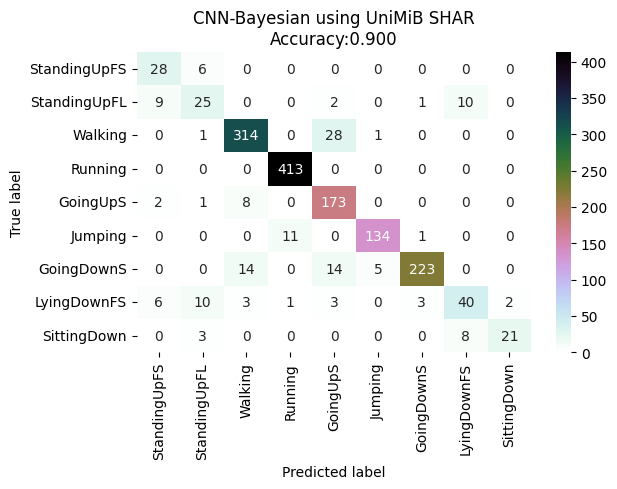

****  UCI HAR  ****
Unzipping UCI_HAR_Dataset.zip file

The validation group is generated using sklearn stratify on train
It is not subject independent - confirm accuracy with test set
array    shape           data type
-------  --------------  -----------
x_train  (5514, 128, 4)  float64
y_train  (5514, 6)       float32
x_valid  (1838, 128, 4)  float64
y_valid  (1838, 6)       float32
x_test   (2947, 128, 4)  float64
y_test   (2947, 6)       float32
Prediction accuracy: 0.829
                    precision    recall  f1-score   support

           WALKING       0.96      0.94      0.95       496
  WALKING_UPSTAIRS       0.99      0.91      0.95       471
WALKING_DOWNSTAIRS       0.89      0.99      0.94       420
           SITTING       0.61      0.57      0.59       491
          STANDING       0.69      0.81      0.75       532
            LAYING       0.88      0.79      0.83       537

          accuracy                           0.83      2947
         macro avg       0.84      0

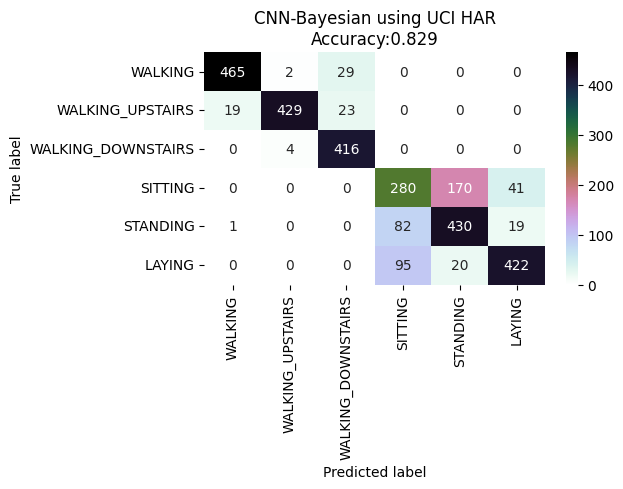

****  TWristAR  ****
Unzipping TWristAR file in . directory


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8
Prediction accuracy: 0.791
              precision    recall  f1-score   support

  Downstairs       0.88      0.55      0.68       173
     Jogging       0.94      0.72      0.81       173
     Sitting       0.88      0.70      0.78       171
    Standing       0.79      0.88      0.83       186
    Upstairs       0.74      0.93      0.82       198
     Walking       0.68      0.93      0.79       190

    accuracy                           0.79      1091
   macro avg       0.82      0.78      0.79      1091
weighted avg       0.81      0.79      0.79      1091



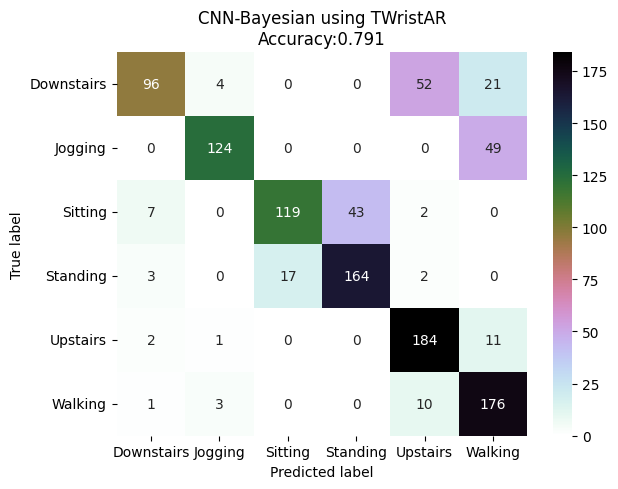

****  Leotta_2021  ****
Unzipping Leotta 2021 dataset into ./dataset
Using source file ./ADL_Leotta_2021.zip


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

array    shape           data type
-------  --------------  -----------
x_train  (2391, 300, 3)  float32
y_train  (2391, 18)      uint8
x_valid  (1167, 300, 3)  float32
y_valid  (1167, 18)      uint8
x_test   (1987, 300, 3)  float32
y_test   (1987, 18)      uint8
Prediction accuracy: 0.314
                  precision    recall  f1-score   support

           OTHER       0.00      0.00      0.00       777
           RELAX       0.00      0.00      0.00        80
KEYBOARD_WRITING       0.18      0.23      0.20        80
          LAPTOP       0.16      0.56      0.25        80
     HANDWRITING       0.49      0.61      0.54        80
     HANDWASHING       0.48      0.33      0.39        80
     FACEWASHING       0.45      0.30      0.36        80
      TEETHBRUSH       0.35      0.54      0.42        80
        SWEEPING       0.36      0.50      0.42        80
       VACUUMING       0.26      0.75      0.39        80
          EATING       0.20      0.51      0.29        80
         DUS

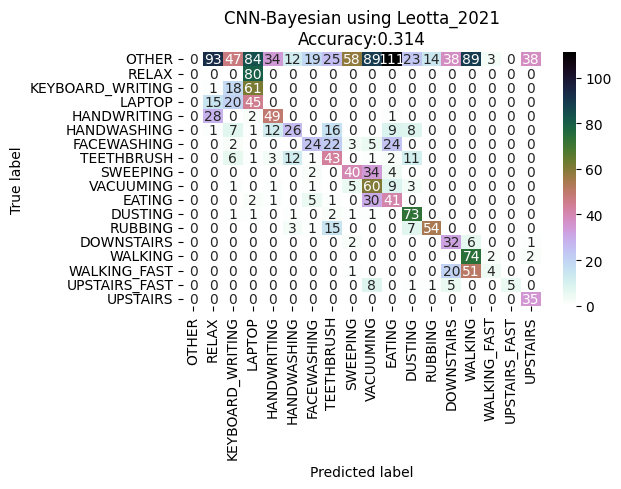

****  Gesture Phase Segmentation  ****
Local load_data_utils.py found, skipping download
Local load_data_transforms.py found, skipping download
Unzipping Gesture Phase Segmentation file in ./gesture_phase_dataset directory
Train: dict_keys(['a1_raw', 'a2_raw', 'a3_raw', 'b1_raw', 'b3_raw'])
Valid: dict_keys([])
Test : dict_keys(['c1_raw', 'c3_raw'])


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


90/10 split of the training group.  It is not subject independent.
Note: Due to the size of the Gesture Phase Segmentation and for 
compatibility, the test arrays are copies of the valid arrays
array    shape          data type
-------  -------------  -----------
x_train  (422, 30, 18)  float32
y_train  (422, 5)       float64
x_valid  (47, 30, 18)   float32
y_valid  (47, 5)        float64
x_test   (47, 30, 18)   float32
y_test   (47, 5)        float64
Prediction accuracy: 0.830
              precision    recall  f1-score   support

        Rest       0.91      0.91      0.91        23
 Preparation       0.50      1.00      0.67         3
      Stroke       1.00      0.83      0.91        18
        Hold       0.00      0.00      0.00         1
  Retraction       0.00      0.00      0.00         2

    accuracy                           0.83        47
   macro avg       0.48      0.55      0.50        47
weighted avg       0.86      0.83      0.84        47



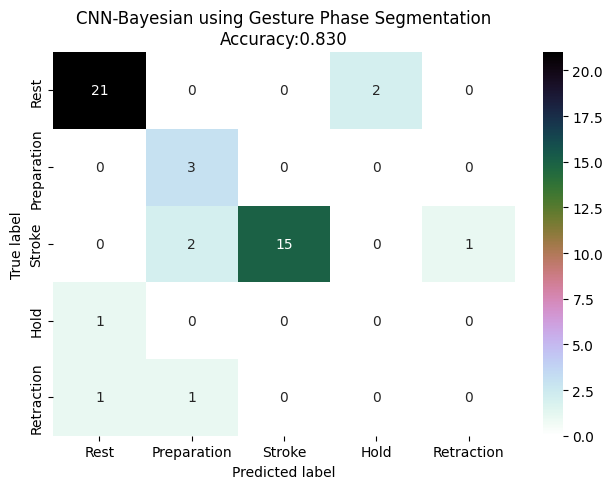

In [14]:
for i in ds_list:
    dataset = i
    print("**** ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)
    # Number of classes
    num_classes = y_train.shape[1]
    y_train_act = np.argmax(y_train, axis=-1)
    sequence = y_train_act
    k = 5  # Maximum number of previous windows to consider
    cpts = learn_cpts(y_train_act, k)
    dl_probs = loaded_probabilities[dataset]  # Probabilities from deep learning model
    bayesian_probs = Bayesian_probabilities(cpts, num_classes, sequence)  # Probabilities from Bayesian model
    lambda_value = 1

    combined_probs = combine_probabilities(dl_probs, bayesian_probs, lambda_value)
    new_y_pred = np.argmax(combined_probs, axis=-1)
    y_test_act = np.argmax(y_test, axis=-1)
    # Print prediction accuracy
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, new_y_pred)))

    # Print a report of classification performance metrics
    print(classification_report(y_test_act, new_y_pred, target_names=t_names))

    # Plot a confusion matrix
    cm = confusion_matrix(y_test_act, new_y_pred)
    cm_df = pd.DataFrame(cm,
                     index = t_names,
                     columns = t_names)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.title('CNN-Bayesian using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, new_y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.show()
